In [41]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

## Import Data

In [42]:

# Load the metadata file
metadata = pd.read_csv(r'..\starting_metadata\metadata.csv')

# Select rows where 'filename_index' contains 'train'
train_files = metadata[metadata['filename_index'].str.contains('train', na=False)]
# Select test files (those not containing 'train' in filename_index)
test_files = metadata[~metadata['filename_index'].str.contains('train', na=False)]

# Select only rows with all metadata (i.e., no missing values)
train_files_with_all_metadata = train_files.dropna()


## Helpers

In [43]:
import geohash2


def add_geohash_column(df,
                       lat_col='Latitude',
                       lon_col='Longitude',
                       precision=5):
    df = df.copy()
    df['geohash'] = df.apply(lambda row: geohash2.encode(
        row[lat_col], row[lon_col], precision=precision),
                             axis=1)
    return df

def summarize_geohash_proximity(df_feat):
    """
    For a dataframe with columns ['geohash', 'Habitat', 'Substrate'],
    returns a summary dataframe with the most common Habitat/Substrate per geohash,
    and the count of unique habitats and substrates per geohash.
    """
    proximity_stats = (
        df_feat.groupby('geohash')[['Habitat', 'Substrate']]
        .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
        .reset_index()
    )

    # Count unique habitats and substrates per geohash
    proximity_counts = (
        df_feat.groupby('geohash')[['Habitat', 'Substrate']]
        .nunique()
        .rename(columns={'Habitat': 'unique_habitats', 'Substrate': 'unique_substrates'})
        .reset_index()
    )

    # Merge stats and counts
    proximity_summary = pd.merge(proximity_stats, proximity_counts, on='geohash')
    return proximity_summary

# Example usage:
# proximity_summary = summarize_geohash_proximity(df_feat)

In [44]:
def plot_geohash_proximity_histograms(proximity_summary):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.histplot(proximity_summary['unique_habitats'], bins=range(1, proximity_summary['unique_habitats'].max()+2), ax=axes[0], discrete=True)
    axes[0].set_title('Unique Habitats per Geohash')
    axes[0].set_xlabel('Number of Unique Habitats')
    axes[0].set_ylabel('Count')

    sns.histplot(proximity_summary['unique_substrates'], bins=range(1, proximity_summary['unique_substrates'].max()+2), ax=axes[1], discrete=True)
    axes[1].set_title('Unique Substrates per Geohash')
    axes[1].set_xlabel('Number of Unique Substrates')
    axes[1].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

## Applying GeoHash

In [45]:
train_files = add_geohash_column(train_files, precision=5)
test_files = add_geohash_column(test_files, precision=5)
# Calculate unique (Latitude, Longitude) pairs for train and test
unique_latlon_train = train_files.dropna(subset=['Latitude', 'Longitude'])[['Latitude', 'Longitude']].drop_duplicates().shape[0]
unique_geohash_train = train_files['geohash'].nunique()

unique_latlon_test = test_files.dropna(subset=['Latitude', 'Longitude'])[['Latitude', 'Longitude']].drop_duplicates().shape[0]
unique_geohash_test = test_files['geohash'].nunique()

print(f"Train: Unique (lat, lon) points = {unique_latlon_train}, unique geohash = {unique_geohash_train}")
print(f"Test: Unique (lat, lon) points = {unique_latlon_test}, unique geohash = {unique_geohash_test}")
print(f"Train reduction: {100 * (1 - unique_geohash_train / unique_latlon_train):.2f}%")
print(f"Test reduction: {100 * (1 - unique_geohash_test / unique_latlon_test):.2f}%")

Train: Unique (lat, lon) points = 882, unique geohash = 585
Test: Unique (lat, lon) points = 8061, unique geohash = 1356
Train reduction: 33.67%
Test reduction: 83.18%


### Looking at dist of habitat and substrate

In [49]:
# Show unique habitats with their number of records
habitat_counts = metadata['Habitat'].value_counts(dropna=False)
print("Unique Habitats and their counts:")
print(habitat_counts)


Unique Habitats and their counts:
Habitat
NaN                                                     24730
Deciduous woodland                                       2942
Mixed woodland (with coniferous and deciduous trees)     1938
coniferous woodland/plantation                           1583
Unmanaged deciduous woodland                             1145
park/churchyard                                           835
Unmanaged coniferous woodland                             391
natural grassland                                         378
lawn                                                      297
roadside                                                  278
Thorny scrubland                                          239
garden                                                    236
Forest bog                                                119
Bog woodland                                              119
hedgerow                                                  100
dune                        

In [50]:
# Show unique substrates with their number of records
substrate_counts = metadata['Substrate'].value_counts(dropna=False)
print("\nUnique Substrates and their counts:")
print(substrate_counts)


Unique Substrates and their counts:
Substrate
NaN                                 24738
soil                                 8341
dead wood (including bark)            958
leaf or needle litter                 899
wood                                  396
stems of herbs, grass etc             115
bark of living trees                  111
mosses                                105
bark                                   87
wood and roots of living trees         71
wood chips or mulch                    57
dead stems of herbs, grass etc         32
other substrate                        20
cones                                  19
faeces                                 18
peat mosses                            15
living stems of herbs, grass etc       11
fungi                                   9
fire spot                               7
fruits                                  3
living leaves                           2
catkins                                 1
Name: count, dtype: int64


Comparisons:
1. geohash -> habitat 
2. geohash -> substrate
3. geohash -> habitat x substrate

Possible encodings:
1. raw
2. One Hot
3. Simplified One Hot (simplify the space)
4. Bag of words
5. BERT
6. BERT + Dim reduction 

Method
1. Unique numbers for the comparison 

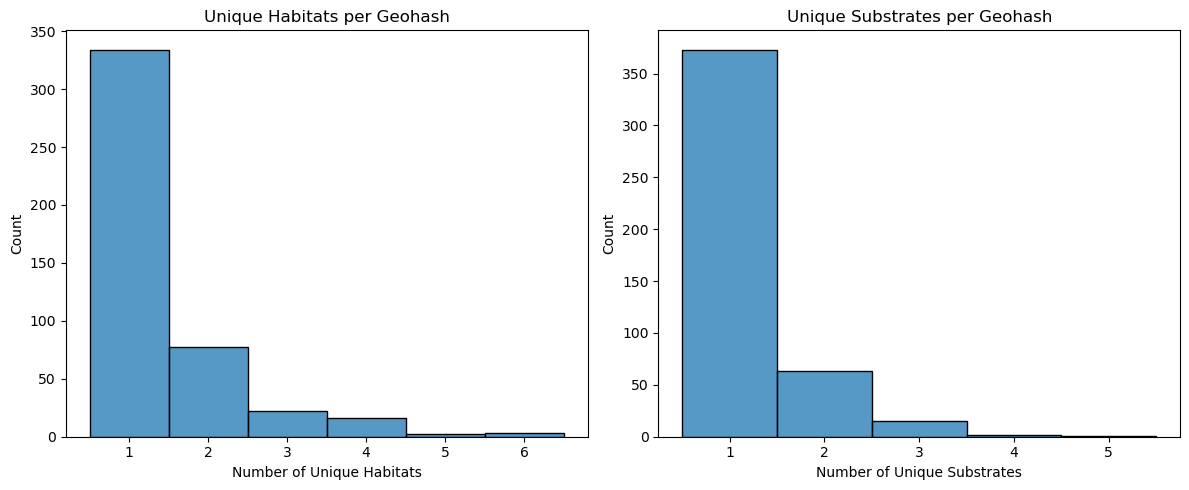

Proportion of geohashes with only one unique habitat: 73.57%
Proportion of geohashes with only one unique substrate: 82.16%
Proportion of geohashes with only one unique habitat-substrate pair: 70.04%


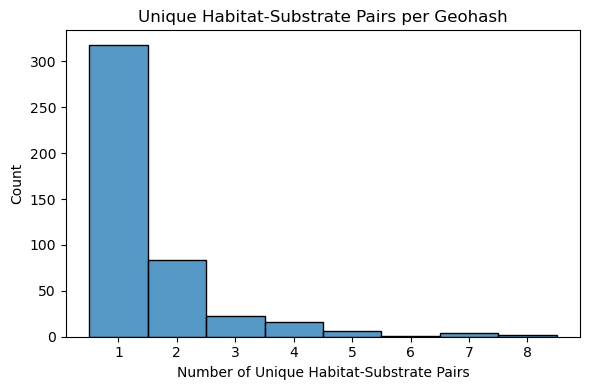

In [46]:
train_proximity_summary = summarize_geohash_proximity(train_files.dropna(subset=['Habitat', 'Substrate']))
plot_geohash_proximity_histograms(train_proximity_summary)
num_geohash = len(train_proximity_summary)
one_habitat = (train_proximity_summary['unique_habitats'] == 1).sum()
one_substrate = (train_proximity_summary['unique_substrates'] == 1).sum()
print(f"Proportion of geohashes with only one unique habitat: {one_habitat / num_geohash:.2%}")
print(
    f"Proportion of geohashes with only one unique substrate: {one_substrate / num_geohash:.2%}"
)
# Count unique (Habitat, Substrate) pairs per geohash
pair_counts = (
    train_files.dropna(subset=['Habitat', 'Substrate'])
    .groupby('geohash')[['Habitat', 'Substrate']]
    .apply(lambda df: df.drop_duplicates().shape[0])
    .reset_index(name='unique_habitat_substrate_pairs')
)

# Summary statistics
one_pair = (pair_counts['unique_habitat_substrate_pairs'] == 1).sum()
print(f"Proportion of geohashes with only one unique habitat-substrate pair: {one_pair / num_geohash:.2%}")

# Optional: plot histogram
plt.figure(figsize=(6,4))
sns.histplot(pair_counts['unique_habitat_substrate_pairs'], bins=range(1, pair_counts['unique_habitat_substrate_pairs'].max()+2), discrete=True)
plt.title('Unique Habitat-Substrate Pairs per Geohash')
plt.xlabel('Number of Unique Habitat-Substrate Pairs')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

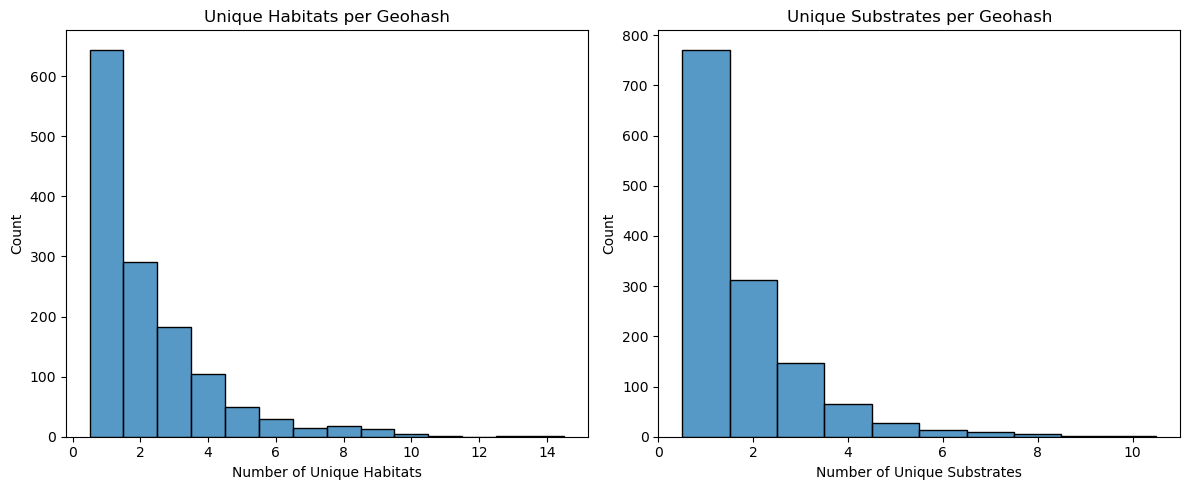

Proportion of test geohashes with only one unique habitat: 47.60%
Proportion of test geohashes with only one unique substrate: 56.98%
Proportion of test geohashes with only one unique habitat-substrate pair: 42.42%


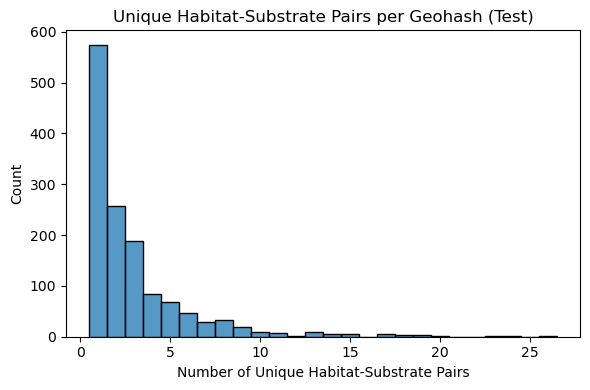

In [47]:
test_proximity_summary = summarize_geohash_proximity(test_files.dropna(subset=['Habitat', 'Substrate']))
plot_geohash_proximity_histograms(test_proximity_summary)
num_geohash_test = len(test_proximity_summary)
one_habitat_test = (test_proximity_summary['unique_habitats'] == 1).sum()
one_substrate_test = (test_proximity_summary['unique_substrates'] == 1).sum()
print(f"Proportion of test geohashes with only one unique habitat: {one_habitat_test / num_geohash_test:.2%}")
print(f"Proportion of test geohashes with only one unique substrate: {one_substrate_test / num_geohash_test:.2%}")

# Count unique (Habitat, Substrate) pairs per geohash for test data
pair_counts_test = (
    test_files.dropna(subset=['Habitat', 'Substrate'])
    .groupby('geohash')[['Habitat', 'Substrate']]
    .apply(lambda df: df.drop_duplicates().shape[0])
    .reset_index(name='unique_habitat_substrate_pairs')
)

one_pair_test = (pair_counts_test['unique_habitat_substrate_pairs'] == 1).sum()
print(f"Proportion of test geohashes with only one unique habitat-substrate pair: {one_pair_test / num_geohash_test:.2%}")

plt.figure(figsize=(6,4))
sns.histplot(pair_counts_test['unique_habitat_substrate_pairs'], bins=range(1, pair_counts_test['unique_habitat_substrate_pairs'].max()+2), discrete=True)
plt.title('Unique Habitat-Substrate Pairs per Geohash (Test)')
plt.xlabel('Number of Unique Habitat-Substrate Pairs')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [79]:
GEOHASH_PRECISION   = 4      # try 4–6 (lower = coarser regions, more stable)
MIN_REGION_COUNT    = 25     # min total samples in a region (or region×season)
MIN_CLASS_COUNT     = 8      # min samples for a specific Habitat/Substrate in region
MIN_PROB_THRESHOLD  = 0.60   # keep priors where p(value | region) ≥ this
TOP_K               = 3      # keep top-k values per region that pass thresholds
MIN_CAT_FREQ_GLOBAL = 10     # merge categories with < this count into "Other"
USE_SEASON_BUCKETS  = True   # if True, build priors per (region, season)

In [80]:
# --- Geohash → {Habitat/Substrate} strong-prior extractor --------------------
# What it does:
# 1) Coarsens geohash precision (or falls back to geocells if no geohash col).
# 2) Merges rare Habitat/Substrate into "Other".
# 3) (Optional) adds Season buckets from eventDate (summer/autumn/other).
# 4) Builds per-region (or region×season) distributions and keeps only
#    confident priors by count & probability thresholds.
# 5) Returns tidy tables + lookup dicts you can use as priors during inference.
#
# Inputs expected in df:
#   - 'geohash' (string). If missing, we’ll create 'geocell' from lat/lon.
#   - 'Habitat', 'Substrate' (strings).
#   - 'eventDate' (parseable to datetime) if use_season=True.



def ensure_region_col(df, gh_prec=GEOHASH_PRECISION):
    out = df.copy()
    if "geohash" in out.columns and out["geohash"].notna().any():
        # coarsen by truncating
        out["region"] = out["geohash"].astype(str).str[:gh_prec].fillna("UNK")
    else:
        # fallback: coarse geocell (≈0.1° bins)
        lat_scaled = out["Latitude"] / 0.1
        lon_scaled = out["Longitude"] / 0.1
        ok = lat_scaled.notna() & lon_scaled.notna() & np.isfinite(lat_scaled) & np.isfinite(lon_scaled)
        lat_bin = lat_scaled.round().where(ok).astype("Int64").astype(str)
        lon_bin = lon_scaled.round().where(ok).astype("Int64").astype(str)
        out["region"] = np.where(ok, lat_bin + "_" + lon_bin, "UNK")
    return out

def add_season(df):
    """Very coarse season buckets: summer (Jun–Aug), autumn (Sep–Oct), other."""
    out = df.copy()
    m = pd.to_datetime(out["eventDate"], errors="coerce").dt.month
    season = pd.Series("other", index=out.index)
    season[m.between(6, 8, inclusive="both")] = "summer"
    season[m.between(9,10, inclusive="both")] = "autumn"
    out["season"] = season
    return out

def merge_rare_categories(df, col, min_freq=MIN_CAT_FREQ_GLOBAL):
    out = df.copy()
    counts = out[col].value_counts(dropna=False)
    rare = counts[counts < min_freq].index
    out[col] = out[col].astype(str)
    out.loc[out[col].isin(rare), col] = "Other"
    out[col] = out[col].fillna("Other")
    return out

def _build_prior(df, value_col, group_cols):
    """Return tidy DF with region (and season), value, prob, count, total, entropy."""
    grp = df.groupby(group_cols + [value_col], dropna=False).size().rename("count").reset_index()
    total = grp.groupby(group_cols)["count"].sum().rename("total_count").reset_index()
    merged = grp.merge(total, on=group_cols, how="left")
    merged["prob"] = merged["count"] / merged["total_count"]
    # per-group entropy (natural logs)
    ent = merged.assign(p=merged["prob"].clip(1e-12, 1)).groupby(group_cols).apply(
        lambda g: -float((g["p"] * np.log(g["p"])).sum())
    ).rename("entropy").reset_index()
    merged = merged.merge(ent, on=group_cols, how="left")
    # filter by thresholds
    filt = (merged["total_count"] >= MIN_REGION_COUNT) & (merged["count"] >= MIN_CLASS_COUNT) & (merged["prob"] >= MIN_PROB_THRESHOLD)
    filtered = merged.loc[filt].copy()
    # keep top-k per group
    filtered["rk"] = filtered.groupby(group_cols)["prob"].rank(method="first", ascending=False)
    filtered = filtered.loc[filtered["rk"] <= TOP_K].drop(columns="rk").sort_values(group_cols + ["prob"], ascending=[True]*len(group_cols) + [False])
    return merged.sort_values(group_cols + ["prob"], ascending=[True]*len(group_cols) + [False]), filtered

def build_location_priors(df_raw):
    df = ensure_region_col(df_raw)
    if USE_SEASON_BUCKETS:
        df = add_season(df)
        group_cols = ["region", "season"]
    else:
        group_cols = ["region"]

    # merge rare categories
    df = merge_rare_categories(df, "Habitat",   MIN_CAT_FREQ_GLOBAL)
    df = merge_rare_categories(df, "Substrate", MIN_CAT_FREQ_GLOBAL)

    # HABITAT priors
    habitat_full, habitat_strong = _build_prior(df, value_col="Habitat", group_cols=group_cols)
    # SUBSTRATE priors
    substrate_full, substrate_strong = _build_prior(df, value_col="Substrate", group_cols=group_cols)

    # Build lookup dicts: (region[, season]) -> list of (value, prob)
    def to_lookup(df_strong, value_col):
        lut = {}
        for row in df_strong[group_cols + [value_col, "prob"]].itertuples(index=False):
            key = tuple(getattr(row, c) for c in group_cols)
            lut.setdefault(key, []).append((getattr(row, value_col), float(getattr(row, "prob"))))
        return lut

    habitat_lookup   = to_lookup(habitat_strong,   "Habitat")
    substrate_lookup = to_lookup(substrate_strong, "Substrate")

    return {
        "group_cols": group_cols,
        "habitat_full": habitat_full,
        "habitat_strong": habitat_strong,
        "substrate_full": substrate_full,
        "substrate_strong": substrate_strong,
        "habitat_lookup": habitat_lookup,
        "substrate_lookup": substrate_lookup,
    }

# ----------------- Usage example -----------------
# df_labeled =  labeled training dataframe with columns:
#   ['geohash', 'Habitat', 'Substrate', 'eventDate', ...]
# priors = build_location_priors(df_labeled)
# # Inspect strongest priors:
# display(priors["habitat_strong"].head(20))
# display(priors["substrate_strong"].head(20))

# ----------------- Applying priors at inference -----------------
def attach_top_prior_cols(df_new, priors, topn=1):
    """Attach columns with top-N prior Habitat/Substrate (and probs) given region(,season)."""
    out = ensure_region_col(df_new)
    if "season" in priors["group_cols"]:
        out = add_season(out)
    gc = priors["group_cols"]

    def pick_top(lut, key, n):
        lst = lut.get(tuple(key), [])
        if len(lst) == 0:
            return [("None", 0.0)] * n
        lst = sorted(lst, key=lambda t: t[1], reverse=True)[:n]
        if len(lst) < n:
            lst += [("None", 0.0)] * (n - len(lst))
        return lst

    h_vals, h_probs, s_vals, s_probs = [], [], [], []
    for row in out.itertuples(index=False):
        key = [getattr(row, c) for c in gc]
        h_top = pick_top(priors["habitat_lookup"], key, topn)
        s_top = pick_top(priors["substrate_lookup"], key, topn)
        # store only the top-1 for convenience; extend as needed
        h_vals.append(h_top[0][0]); h_probs.append(h_top[0][1])
        s_vals.append(s_top[0][0]); s_probs.append(s_top[0][1])

    out = out.copy()
    out["prior_habitat_top1"]   = h_vals
    out["prior_habitat_p_top1"] = h_probs
    out["prior_substrate_top1"]   = s_vals
    out["prior_substrate_p_top1"] = s_probs
    return out


def habitat_prior_logit_vector(habitat_value, prob, all_habitats):
    """
    Turn a (top habitat, prob) into a logit vector over habitats (for quick ablations).
    Uses log-odds, with small epsilon smoothing. Map to your class space if you build
    species priors conditioned on habitat.
    """
    eps = 1e-4
    logits = np.full(len(all_habitats), np.log(eps/(1-eps)), dtype=float)
    if habitat_value in all_habitats:
        i = all_habitats.index(habitat_value)
        p = np.clip(prob, eps, 1-eps)
        logits[i] = np.log(p/(1-p))
    return logits


In [81]:
train_complete = train_files.dropna(subset=['geohash', 'Habitat', 'Substrate', 'eventDate'])


In [82]:
GEOHASH_PRECISION   = 5
priors = build_location_priors(train_complete)
display(priors["habitat_strong"].head(20))
display(priors["substrate_strong"].head(20))

C:\Users\ngrec\AppData\Local\Temp\ipykernel_46876\2733038385.py:58: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ent = merged.assign(p=merged["prob"].clip(1e-12, 1)).groupby(group_cols).apply(
C:\Users\ngrec\AppData\Local\Temp\ipykernel_46876\2733038385.py:58: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ent = merged.assign(p=merged["prob"].clip(1e-12, 1)).groupby(group_cols).apply(


,region,season,Habitat,count,total_count,prob,entropy


,region,season,Substrate,count,total_count,prob,entropy
234,u3bv,autumn,soil,28,38,0.736842,0.913138
242,u3bv,summer,soil,39,40,0.975000,0.116907
245,u3bw,autumn,soil,26,32,0.812500,0.567058


In [83]:
GEOHASH_PRECISION   = 4
priors = build_location_priors(train_complete)
display(priors["habitat_strong"].head(20))
display(priors["substrate_strong"].head(20))

C:\Users\ngrec\AppData\Local\Temp\ipykernel_46876\2733038385.py:58: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ent = merged.assign(p=merged["prob"].clip(1e-12, 1)).groupby(group_cols).apply(
C:\Users\ngrec\AppData\Local\Temp\ipykernel_46876\2733038385.py:58: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ent = merged.assign(p=merged["prob"].clip(1e-12, 1)).groupby(group_cols).apply(


,region,season,Habitat,count,total_count,prob,entropy


,region,season,Substrate,count,total_count,prob,entropy
234,u3bv,autumn,soil,28,38,0.736842,0.913138
242,u3bv,summer,soil,39,40,0.975000,0.116907
245,u3bw,autumn,soil,26,32,0.812500,0.567058


In [84]:
GEOHASH_PRECISION   = 6
priors = build_location_priors(train_complete)
display(priors["habitat_strong"].head(20))
display(priors["substrate_strong"].head(20))

C:\Users\ngrec\AppData\Local\Temp\ipykernel_46876\2733038385.py:58: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ent = merged.assign(p=merged["prob"].clip(1e-12, 1)).groupby(group_cols).apply(
C:\Users\ngrec\AppData\Local\Temp\ipykernel_46876\2733038385.py:58: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ent = merged.assign(p=merged["prob"].clip(1e-12, 1)).groupby(group_cols).apply(


,region,season,Habitat,count,total_count,prob,entropy


,region,season,Substrate,count,total_count,prob,entropy
234,u3bv,autumn,soil,28,38,0.736842,0.913138
242,u3bv,summer,soil,39,40,0.975000,0.116907
245,u3bw,autumn,soil,26,32,0.812500,0.567058


In [85]:
GEOHASH_PRECISION   = 6
USE_SEASON_BUCKETS  = False
priors = build_location_priors(train_complete)
display(priors["habitat_strong"].head(20))
display(priors["substrate_strong"].head(20))

C:\Users\ngrec\AppData\Local\Temp\ipykernel_46876\2733038385.py:58: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ent = merged.assign(p=merged["prob"].clip(1e-12, 1)).groupby(group_cols).apply(
C:\Users\ngrec\AppData\Local\Temp\ipykernel_46876\2733038385.py:58: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ent = merged.assign(p=merged["prob"].clip(1e-12, 1)).groupby(group_cols).apply(


,region,Habitat,count,total_count,prob,entropy
263,u3bu,park/churchyard,22,33,0.666667,1.251921
289,u3by,Deciduous woodland,28,44,0.636364,1.248366


,region,Substrate,count,total_count,prob,entropy
57,u1z3,soil,19,30,0.633333,1.037097
102,u38r,soil,32,33,0.969697,0.135794
156,u3bu,soil,27,33,0.818182,0.658031
161,u3bv,soil,68,88,0.772727,0.861088
168,u3bw,soil,50,69,0.724638,0.936816
175,u3by,soil,30,44,0.681818,1.093261


In [89]:
test_with_priors = attach_top_prior_cols(test_files, priors, topn=1)
test_with_priors


,filename_index,Habitat,Latitude,Longitude,Substrate,eventDate,taxonID_index,geohash,region,prior_habitat_top1,prior_habitat_p_top1,prior_substrate_top1,prior_substrate_p_top1
0,fungi_final000000.jpg,Mixed woodland (with coniferous and deciduous ...,54.994548,11.958746,soil,2018-09-01,NaN,u3b8b,u3b8,None,0.000000,None,0.000000
1,fungi_final000001.jpg,Unmanaged deciduous woodland,54.673140,11.464060,soil,2013-07-14,NaN,u38ph,u38p,None,0.000000,None,0.000000
2,fungi_final000002.jpg,Forest bog,56.123620,9.492040,leaf or needle litter,2011-05-29,NaN,u1yxr,u1yx,None,0.000000,None,0.000000
3,fungi_final000003.jpg,coniferous woodland/plantation,55.695150,12.338600,soil,2013-11-06,NaN,u3bub,u3bu,park/churchyard,0.666667,soil,0.818182
4,fungi_final000004.jpg,Deciduous woodland,56.148944,9.961819,soil,2020-10-12,NaN,u1zp6,u1zp,None,0.000000,None,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10147,fungi_test006547.jpg,coniferous woodland/plantation,55.808324,12.519929,soil,2020-09-23,NaN,u3bvk,u3bv,None,0.000000,soil,0.772727
10148,fungi_test006548.jpg,Deciduous woodland,55.795684,12.397473,soil,2016-08-02,NaN,u3bv6,u3bv,None,0.000000,soil,0.772727
10149,fungi_test006549.jpg,Deciduous woodland,56.255820,10.761435,dead wood (including bark),2018-10-25,NaN,u4p8h,u4p8,None,0.000000,None,0.000000
10150,fungi_test006550.jpg,Unmanaged deciduous woodland,56.097046,10.241409,soil,2020-09-17,NaN,u1zr1,u1zr,None,0.000000,None,0.000000
